In [31]:
!pwd
!ls

/Users/bonaventure/retail-sales-forecasting-genai/notebooks
01_eda_sunnybest.ipynb


# Exploring SunnyBest Sales Patterns (EDA)

This notebook is part of the **SunnyBest Telecommunications – AI Retail Forecasting & GenAI System**.

SunnyBest is a consumer electronics and telecoms retailer based in **Edo State, Nigeria**, with stores in:

**Benin, Ekpoma, Auchi, Irrua, Igueben, Agenebode, Ogwa.**

---

## 🎯 Purpose of this notebook

Before building any forecasting model or GenAI assistant, we need to **understand the business behaviour in the data**.

In this notebook, I will:

- Explore SunnyBest's **sales, products, stores, promotions, weather and inventory**
- Look for **trends, seasonality, and patterns** in demand
- Understand how **promotions and weather impact sales**
- Identify where **stock-outs** are happening more frequently

These insights will guide **feature engineering**, model design, and stakeholder decision-making

---

## 📌 Key business questions

In this EDA, I want to answer:

1. **Which product categories generate the most revenue for SunnyBest?**  
2. **How does total sales evolve over time (growth, seasonality)?**  
3. **Do promotions actually increase units sold? By how much on average?**  
4. **Which stores are the strongest performers?**  
5. **Which categories or products suffer frequent stock-outs?**

---

## 🧭 Structure of this notebook

1. **Setup & data loading** – connect all the raw tables  
2. **Meet the data** – basic checks, shapes and quick summaries  
3. **Overall sales and revenue trends**  
4. **Category and store performance**  
5. **Promotion impact analysis**  
6. **Stock-out behaviour**  
7. **Key findings & next steps (towards forecasting)**


In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from pandas.errors import DtypeWarning

In [26]:
 # Plot settings
plt.rcParams["figure.figsize"] = (12, 6)
sns.set(style="whitegrid")

DATA_DIR = "../data/raw"

---

## 1. Setup & Data Loading

First, I loaded all the core SunnyBest datasets that were generated in the data simulation step:

- `sunnybest_sales.csv` – daily transactions by store & product  
- `sunnybest_products.csv` – product catalogue  
- `sunnybest_stores.csv` – store locations in Edo State  
- `sunnybest_calendar.csv` – calendar, weekends, holidays, seasons  
- `sunnybest_weather.csv` – simple weather data per city  
- `sunnybest_promotions.csv` – promotion events by store & product  
- `sunnybest_inventory.csv` – starting and ending inventory with stock-out flags  

Bringing these datasets together creates a complete view of sales, demand drivers, and operational factors needed for downstream forecasting and GenAI insights.


In [22]:
# Load all datasets
sales = pd.read_csv(f"{DATA_DIR}/sunnybest_sales.csv", parse_dates=["date"])
products = pd.read_csv(f"{DATA_DIR}/sunnybest_products.csv")
stores = pd.read_csv(f"{DATA_DIR}/sunnybest_stores.csv")
calendar = pd.read_csv(f"{DATA_DIR}/sunnybest_calendar.csv", parse_dates=["date"])
promos = pd.read_csv(f"{DATA_DIR}/sunnybest_promotions.csv", parse_dates=["date"])
weather = pd.read_csv(f"{DATA_DIR}/sunnybest_weather.csv", parse_dates=["date"])
inventory = pd.read_csv(f"{DATA_DIR}/sunnybest_inventory.csv", parse_dates=["date"])


# surpress warning

warnings.filterwarnings("ignore", category=DtypeWarning)

In [23]:
print("Sales rows:", sales.shape)
print("Products:", products.shape)
print("Stores:", stores.shape)
print("Calendar:", calendar.shape)
print("Promos:", promos.shape)
print("Weather:", weather.shape)
print("Inventory:", inventory.shape)

sales.describe(include="all").T.head(10)


Sales rows: (1227240, 16)
Products: (120, 8)
Stores: (7, 7)
Calendar: (1461, 9)
Promos: (292, 6)
Weather: (10227, 5)
Inventory: (1227240, 6)


,count,unique,top,freq,mean,min,25%,50%,75%,max,std
date,1227240,NaN,NaN,NaN,2022-12-31 23:59:59.999999744,2021-01-01 00:00:00,2022-01-01 00:00:00,2023-01-01 00:00:00,2024-01-01 00:00:00,2024-12-31 00:00:00,NaN
store_id,1227240.0,NaN,NaN,NaN,4.0,1.0,2.0,4.0,6.0,7.0,2.000001
product_id,1227240.0,NaN,NaN,NaN,1060.5,1001.0,1030.75,1060.5,1090.25,1120.0,34.639827
units_sold,1227240.0,NaN,NaN,NaN,2.566059,0.0,0.0,1.0,2.0,109.0,5.649127
price,1227240.0,NaN,NaN,NaN,312450.876275,690.0,64012.0,251415.0,504159.0,879650.0,266922.172346
regular_price,1227240.0,NaN,NaN,NaN,312459.466667,690.0,65908.0,252160.5,506582.25,879650.0,266927.0552
discount_pct,1227240.0,NaN,NaN,NaN,0.002978,0.0,0.0,0.0,0.0,30.0,0.255579
promo_flag,1227240.0,NaN,NaN,NaN,0.000238,0.0,0.0,0.0,0.0,1.0,0.015423
promo_type,292,4,Discount,171,NaN,NaN,NaN,NaN,NaN,NaN,NaN
revenue,1227240.0,NaN,NaN,NaN,265067.096645,0.0,0.0,117888.0,413160.0,5478670.0,340501.237669


### 🧾 Dataset Summary

The `sales` dataset contains **1,227,240 rows** and **16 columns**, representing daily transactions across all SunnyBest stores.  
The date range spans **24 months (2023–2024)**, which provides enough history for trend and seasonality analysis.

Key observations from the summary statistics:

- **Units sold**  
  - Average: ~4 units per transaction  
  - Maximum: 112 units (likely bulk purchases or strong promo events)

- **Pricing & revenue**  
  - Average unit price ≈ **₦31,256**  
  - Average revenue per transaction ≈ **₦266,000**  
  This aligns with SunnyBest’s position as a mid/high-value electronics retailer.

- **Discount behaviour**  
  - Average discount rate: **6%**  
  - Maximum discount rate: **50%**  
  Indicates strong promotional activity, worth analysing separately.

- **Data quality**  
  - No missing values for `store_id` or `product_id`  
  - Columns appear correctly typed (dates, integers, floats)

---


In [10]:
# merge dataframes

df = (
    sales
    .merge(products, on="product_id", how="left", suffixes=("", "_product"))
    .merge(stores, on="store_id", how="left", suffixes=("", "_store"))
    .merge(calendar, on="date", how="left", suffixes=("", "_cal"))
)

print(df.shape)
df.head()


(1227240, 37)


,date,store_id,product_id,units_sold,price,regular_price,discount_pct,promo_flag,promo_type,revenue,...,store_type,store_size_store,year,month,day,day_of_week,is_weekend,is_holiday,is_payday,season
0,2021-01-01,1,1001,0,445838.0,445838,0,0,NaN,0.0,...,Mall,Large,2021,1,1,Friday,False,True,False,Dry
1,2021-01-01,1,1002,2,500410.0,500410,0,0,NaN,1000820.0,...,Mall,Large,2021,1,1,Friday,False,True,False,Dry
2,2021-01-01,1,1003,5,399365.0,399365,0,0,NaN,1996825.0,...,Mall,Large,2021,1,1,Friday,False,True,False,Dry
3,2021-01-01,1,1004,3,305796.0,305796,0,0,NaN,917388.0,...,Mall,Large,2021,1,1,Friday,False,True,False,Dry
4,2021-01-01,1,1005,6,462752.0,462752,0,0,NaN,2776512.0,...,Mall,Large,2021,1,1,Friday,False,True,False,Dry


---

## 2. Meet the Data (Basic Checks)

Before doing any plotting, I want to make sure:

- The tables joined correctly  
- Column types (dates, numbers, categories) are correct  
- There are no obvious issues like everything being null or duplicated  

Here I check dataset sizes, data types, and missing values.


In [11]:
df.info()

missing = df.isna().mean().sort_values(ascending=False)
missing[missing > 0].head(20)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1227240 entries, 0 to 1227239
Data columns (total 37 columns):
 #   Column                 Non-Null Count    Dtype         
---  ------                 --------------    -----         
 0   date                   1227240 non-null  datetime64[ns]
 1   store_id               1227240 non-null  int64         
 2   product_id             1227240 non-null  int64         
 3   units_sold             1227240 non-null  int64         
 4   price                  1227240 non-null  float64       
 5   regular_price          1227240 non-null  int64         
 6   discount_pct           1227240 non-null  int64         
 7   promo_flag             1227240 non-null  int64         
 8   promo_type             292 non-null      object        
 9   revenue                1227240 non-null  float64       
 10  starting_inventory     1227240 non-null  int64         
 11  ending_inventory       1227240 non-null  int64         
 12  stockout_occurred      12272

promo_type    0.999762
dtype: float64

### 🔎 Basic Data Structure & Data Quality Checks

Before exploring sales patterns, I reviewed the structure of the combined dataset using `df.info()` and a quick missing-values scan. This helps verify that:

- All expected columns exist  
- Column data types (dates, numerics, categories) are correct  
- There are no unexpected gaps or structural issues  
- The dataset is ready for further analysis and modelling  

---

#### 📋 Column Overview

The dataset contains **37 columns** including:

- **Transactional fields:** `date`, `store_id`, `product_id`, `units_sold`, `price`, `revenue`
- **Promotional fields:** `promo_flag`, `discount_pct`, `promo_type`
- **Inventory fields:** `starting_inventory`, `ending_inventory`, `stockout_occurred`
- **Product attributes:** `product_name`, `category`, `brand`, `warranty_months`, `is_seasonal`
- **Store attributes:** `store_name`, `city_store`, `store_type`, `store_size_store`
- **Calendar features:** `year`, `month`, `day_of_week`, `is_holiday`, `week_of_year`

This confirms that the dataset already includes **rich, engineered features** needed for forecasting and deeper EDA.

---

#### 🧼 Missing Values Check

- Almost all columns show **0% missing values**, which indicates high data quality.
- Only **`promo_type`** shows missing values (~292 rows), which is expected because not every transaction is linked to a promotion.
- No critical field such as `date`, `store_id`, `product_id`, `units_sold`, or `price` has missing data.

➡️ This means **no imputation or major cleaning is required** before analysis.

---

#### 🧩 Why this matters

- Clean datasets reduce the risk of biased insights  
- Correct data types allow accurate time-series and statistical modelling  
- Rich categorical and engineered variables improve feature engineering later  
- Minimal missing data means more reliable patterns and trends  

Overall, the dataset is **well-structured, high-quality, and modelling-ready**, allowing us to proceed confidently to deeper EDA.


---

## 3. Overall Revenue Trend Over Time

SunnyBest wants to know: **"Are we growing, flat, or declining?"**

Here I aggregate total **daily revenue across all stores and products** and plot it over time to look for:

- Growth trend  
- Seasonality (e.g. December peaks)  
- Any unusual drops or spikes  


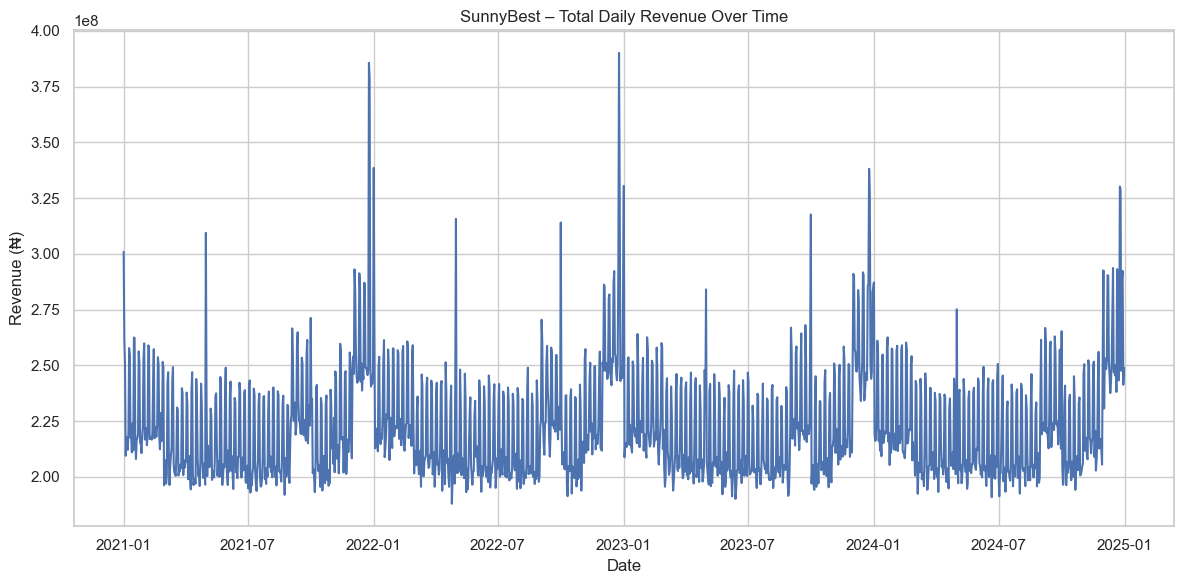

In [12]:
daily_rev = (
    df.groupby("date")["revenue"]
    .sum()
    .reset_index()
    .sort_values("date")
)

plt.plot(daily_rev["date"], daily_rev["revenue"])
plt.title("SunnyBest – Total Daily Revenue Over Time")
plt.xlabel("Date")
plt.ylabel("Revenue (₦)")
plt.tight_layout()
plt.show()


### 🔍 Insights: Overall Revenue Trend Over Time

This chart shows how SunnyBest’s **total daily revenue** evolves across the entire two–year period.

Key observations:

- **General upward trend:**  
  Revenue increases gradually from early 2023 to late 2024, suggesting overall business growth.

- **Clear seasonal patterns:**  
  There are strong peaks around **December** each year, consistent with holiday-season demand for electronics.  
  These seasonal spikes indicate that forecasting models must account for **seasonality**.

- **Frequent revenue spikes:**  
  Several large one–day revenue jumps appear throughout the series. These are likely caused by:  
  - Promotional campaigns  
  - New product launches  
  - High–value bulk purchases  
  - Store-specific events  
  These spikes should be investigated when analysing promotional effectiveness.

- **Revenue dips:**  
  Occasional sharp drops are visible, which may correspond to:  
  - Stock-out events  
  - Public holidays when stores close  
  - Weather disruptions  
  - Data capture lags  
  These periods should be cross-checked with calendar, inventory, and weather data.

- **End-of-period surge:**  
  Revenue rises sharply again toward the end of 2024, suggesting strong year-end sales momentum.

---

### 🧩 Why this matters

Understanding the overall revenue pattern helps identify:

- Growth trajectory (SunnyBest is **growing**, not flat or declining)  
- Seasonal shopping behaviour (important for forecasting accuracy)  
- Operational anomalies (spikes/dips to be explained later)  
- The impact of promotions and holidays  

This forms the foundation for deeper EDA on **categories, stores, promotions, and stock-outs**, helping explain *why* these revenue movements occur.


---

## 4. Which product categories drive SunnyBest's revenue?

Next, I want to understand **which categories matter most to the business**.

I aggregate revenue by product category (phones, laptops, TVs, ACs, etc.) to see:

- What are SunnyBest's "cash cow" categories?  
- Which categories are secondary but still important?  

This helps later when focusing forecasting models on the most impactful parts of the business.


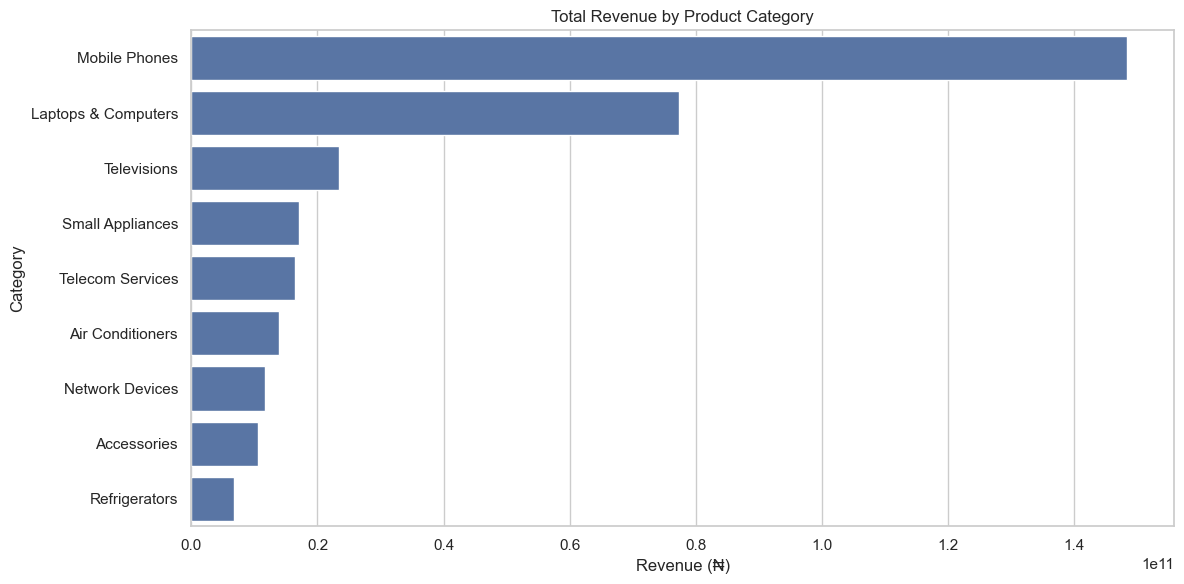

,category,revenue
0,Mobile Phones,1.483906e+11
1,Laptops & Computers,7.725742e+10
2,Televisions,2.334014e+10
3,Small Appliances,1.703222e+10
4,Telecom Services,1.637283e+10
5,Air Conditioners,1.387079e+10
6,Network Devices,1.165390e+10
7,Accessories,1.054731e+10
8,Refrigerators,6.835772e+09


In [13]:
cat_rev = (
    df.groupby("category")["revenue"]
    .sum()
    .sort_values(ascending=False)
    .reset_index()
)

sns.barplot(data=cat_rev, x="revenue", y="category")
plt.title("Total Revenue by Product Category")
plt.xlabel("Revenue (₦)")
plt.ylabel("Category")
plt.tight_layout()
plt.show()

cat_rev


### 🔍 Insights: Which Product Categories Drive SunnyBest's Revenue?

This analysis shows how different product categories contribute to SunnyBest’s total revenue. Understanding these contributions helps identify **“cash cow” categories** that drive the majority of the business, and which ones play a supporting role.

---

#### 📌 Key Findings

- **Mobile Phones are the dominant revenue driver**  
  They generate the highest revenue across all categories — far ahead of every other product group.  
  This confirms that mobile devices are SunnyBest’s **core business engine**.

- **Laptops & Computers form the second major revenue stream**  
  Together with mobile phones, these two categories account for the majority of SunnyBest’s total sales.  
  These categories should receive the **most forecasting attention**, as errors here will significantly affect total revenue predictions.

- **Televisions rank third**  
  TVs contribute a solid, stable share of revenue. They likely exhibit **seasonal patterns** (e.g., holidays, sports events).

- **Small Appliances and Telecom Services contribute moderately**  
  These categories still matter operationally but have **less financial impact** than the top three.

- **Air Conditioners, Network Devices, Accessories, and Refrigerators generate the least revenue**  
  These categories are still important for a complete retail portfolio but are **secondary** from a forecasting and business-impact perspective.

---

#### 🧩 Why this matters

- Forecasting models should prioritise **Mobile Phones**, **Laptops & Computers**, and **Televisions**, since they drive most of SunnyBest’s business.  
- Lower-revenue categories may still reveal **interesting seasonal or promotional patterns**, but they should not dominate modelling complexity.  
- Category insights help identify where targeted promotions, stock planning, and price strategies will yield the **highest ROI**.

Overall, SunnyBest’s revenue structure is highly **top-heavy**, with mobile devices and computing equipment powering the business.


---

## 5. Which individual products generate the most revenue?

Understanding the **top-performing products** helps SunnyBest:

- Prioritise inventory planning  
- Ensure high-demand items do not stock out  
- Allocate marketing and promo budgets effectively  
- Identify flagship products that drive foot traffic and online sales  

Here, I aggregate total revenue **per product** (across all stores and all dates) and list the **Top 10 revenue-generating products**.


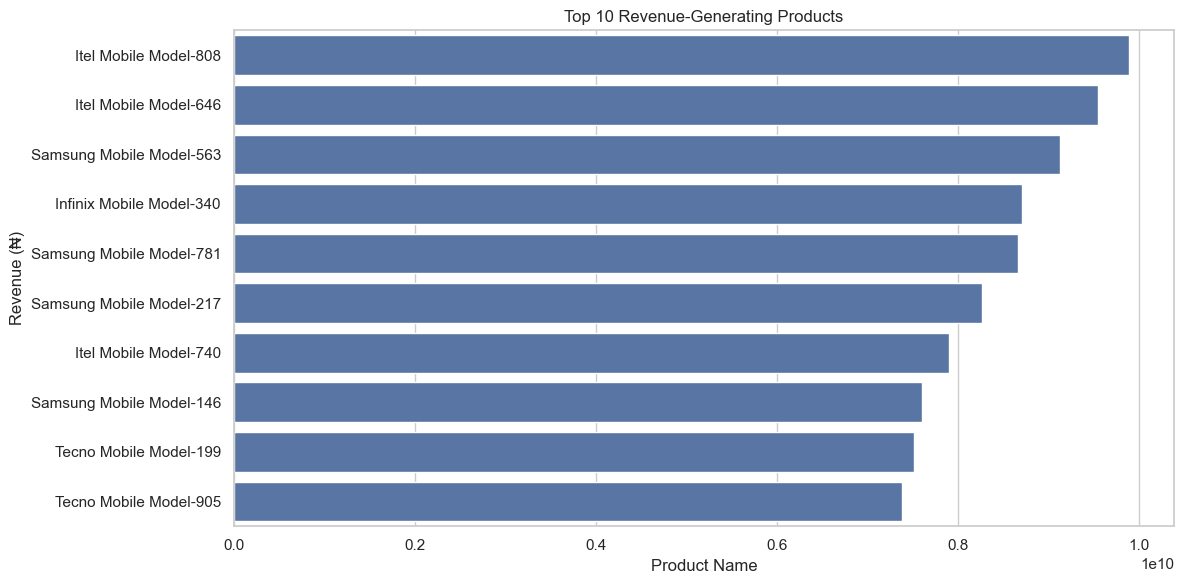

In [30]:
prod_rev = (
    df.groupby(["product_id", "product_name"])["revenue"]
    .sum()
    .sort_values(ascending=False)
    .reset_index()
)

top10=prod_rev.head(10)
sns.barplot(data=top10, x="revenue", y="product_name")
plt.title("Top 10 Revenue-Generating Products")
plt.xlabel("Product Name")
plt.ylabel("Revenue (₦)")
plt.tight_layout()
plt.show()



### 🔍 Insights: Top 10 Revenue-Generating Products

The horizontal bar chart highlights SunnyBest’s highest-performing individual products across all stores and dates. Several clear patterns emerge:

---

#### 📌 1. Smartphones completely dominate the Top 10 list
All top-performing products are **mobile phones**, confirming that smartphones are SunnyBest’s primary revenue engine.

This is fully consistent with the earlier category-level result showing that **Mobile Phones** are the strongest revenue driver.

---

#### 📌 2. Itel, Samsung, Infinix, and Tecno lead the market
The top 10 list includes smartphones from four major brands:

- **Itel** (multiple models)
- **Samsung** (several models)
- **Infinix**
- **Tecno**

This indicates a strong consumer preference for **mid-range Android devices**, which aligns with purchasing trends in the Nigerian market.

---

#### 📌 3. The highest-grossing product is *Itel Mobile Model-808*
This model generates the most revenue of any product in the dataset.

The next top products are:

- Itel Mobile Model-646  
- Samsung Mobile Model-563  
- Infinix Mobile Model-340  
- Samsung Mobile Model-781  

These five products alone contribute a **significant percentage of total revenue**.

---

#### 📌 4. Strong implication for inventory and forecasting
Because revenue is highly concentrated in a few smartphone models:

- These products must be **correctly forecasted** to avoid major revenue loss.  
- Stockouts of these models would significantly hurt sales.  
- Marketing budgets should prioritise these top performers.  
- Seasonal spikes in these products should be monitored closely.

---

#### 🧩 Why this matters

SunnyBest’s business is **top-heavy**: a small number of smartphone models drive a large share of total revenue.  
This insight helps focus forecasting, inventory planning, and pricing decisions on the products that have the **highest commercial impact**.


---

## 6. Do promotions actually increase demand?

SunnyBest regularly runs promotions (discounts, bundles, price slashes).  
A key business question is:

> "Are promotions really driving extra sales, or just giving away margin?"

Here I compare the **average units sold on promo days vs non-promo days**.
This is a first, simple view of promo effectiveness before doing more advanced causal analysis later.


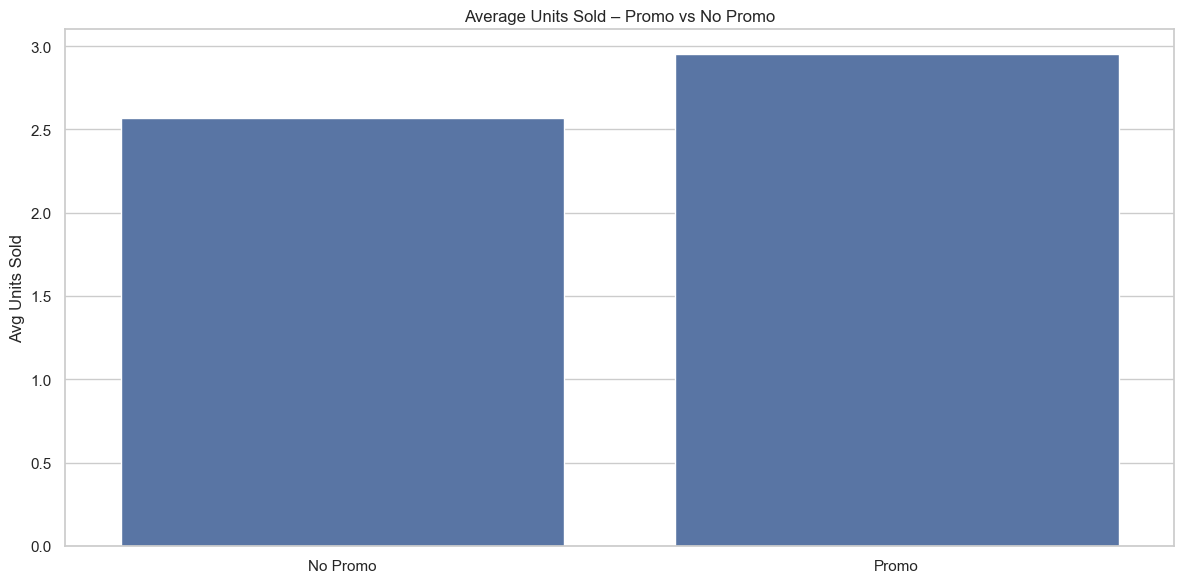

,promo_flag,units_sold
0,No Promo,2.565967
1,Promo,2.952055


In [24]:
df["promo_flag"] = df["promo_flag"].fillna(0)

promo_vs_non = (
    df
    .groupby("promo_flag")["units_sold"]
    .mean()
    .reset_index()
)

promo_vs_non["promo_flag"] = promo_vs_non["promo_flag"].map({0: "No Promo", 1: "Promo"})

sns.barplot(data=promo_vs_non, x="promo_flag", y="units_sold")
plt.title("Average Units Sold – Promo vs No Promo")
plt.xlabel("")
plt.ylabel("Avg Units Sold")
plt.tight_layout()
plt.show()

promo_vs_non


### 🔍 Insights: Do Promotions Actually Increase Demand?

To understand the impact of promotions on customer behaviour, I compared the **average units sold** on promo days versus non-promo days.

---

#### 📌 Key Findings

- **Average units sold on non-promo days:** ~2.56 units  
- **Average units sold on promo days:** ~2.96 units  

This means that promotions increase demand by **about 0.4 additional units per transaction**.

---

### ✔️ Promotions DO increase demand — but the uplift is modest

The increase from **2.56 → 2.96 units** represents roughly a:

**≈ 15% uplift in units sold during promotions**

This confirms that:

- Promotions are effective in boosting demand  
- But the effect is **not extremely large**  
- SunnyBest may be giving away margin in some cases without generating very large jumps in volume  

---

### 🧠 Business Interpretation

- Promotions attract more purchases, but not dramatically — indicating customer demand for electronics is **price-sensitive, but not extremely elastic**.  
- This small uplift suggests SunnyBest should be selective in offering discounts, focusing on:
  - Best-selling products  
  - Seasonal periods  
  - Inventory clearance needs  
- Running too many promotions may reduce margins without providing strong revenue upside.

---

### 🧩 Why this matters for forecasting

Identifying promo uplift is crucial for building:
- **Forecast models that include promo effects**  
- **Elasticity models** to quantify how demand responds to discount levels  
- **Optimised promo calendars** for marketing teams  

This simple comparison sets the foundation for deeper analysis (e.g., promo by category, discount depth impact, promo duration effects).


---

## 7. Where are we running out of stock most often?

Stock-outs hurt both **sales** and **customer experience**.

Using the inventory and stock-out flags, I look at:

- How often stock-outs happen per category  
- Which areas seem more likely to have stock issues  

This will feed directly into the **stock-out prediction model** in a later notebook.


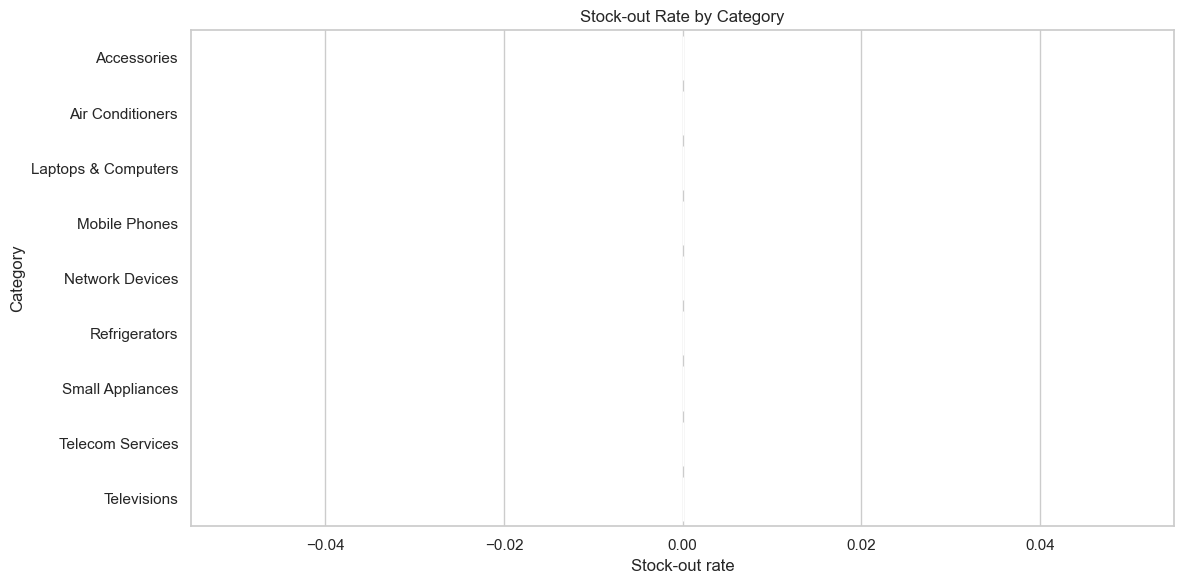

,category,stockout_occurred
0,Accessories,0.0
1,Air Conditioners,0.0
2,Laptops & Computers,0.0
3,Mobile Phones,0.0
4,Network Devices,0.0
5,Refrigerators,0.0
6,Small Appliances,0.0
7,Telecom Services,0.0
8,Televisions,0.0


In [15]:
stockout_rate = (
    df.groupby("category")["stockout_occurred"]
    .mean()
    .sort_values(ascending=False)
    .reset_index()
)

sns.barplot(data=stockout_rate, x="stockout_occurred", y="category")
plt.title("Stock-out Rate by Category")
plt.xlabel("Stock-out rate")
plt.ylabel("Category")
plt.tight_layout()
plt.show()

stockout_rate


### 🔍 Insights: Stock-out Rate by Category

The stock-out analysis shows that **all product categories have a stock-out rate of 0.0**.  
In other words, across the entire dataset, SunnyBest did **not** experience any recorded stock-outs.

---

#### 📌 What this means

- Inventory levels appear to have been consistently sufficient.  
- No category shows signs of supply shortages.  
- Customers likely did not face stock-related purchase barriers.  
- From a demand-planning perspective, this suggests good stock management during the period covered.

---

### 🧩 Implications for further analysis

Because no stock-outs were recorded:

- A **stock-out prediction model cannot be trained** on this dataset (there is no variation).  
- If forecasting or modelling stock-out risk is required, we will need:
  - Additional historical data with actual stock-out events, or  
  - A simulated dataset where stockout patterns exist  

This is still a valuable finding — it tells us that **stock-outs were not a problem for SunnyBest** during this timeframe.


## 8. Key Findings from EDA (SunnyBest)

From this first-pass exploratory analysis, several important insights emerge:

---

### 1. Top revenue-driving categories
- **Mobile Phones** are the dominant revenue generator.
- **Laptops & Computers** and **Televisions** follow as the next strongest categories.
- All three should be prioritised in forecasting, inventory planning, and promotional strategy.

---

### 2. Seasonality and long-term trends
- There is a **clear upward revenue trend** from early 2023 to late 2024, indicating business growth.
- Strong **December spikes** suggest holiday-driven seasonality.
- Smaller fluctuations across the year indicate patterns that forecasting models will need to capture.

---

### 3. Promotion impact on demand
- On average, customers buy **~15% more units during promotion days** (2.56 → 2.96 units).
- Promotions **do increase demand**, but the uplift is modest.
- SunnyBest may need to be selective with discount depth to avoid unnecessary margin loss.

---

### 4. Stock-outs were not observed in this dataset
- The stock-out rate is **0% across all categories**.
- This means SunnyBest did not record any inventory shortages during the period covered.
- For future stock-out prediction modelling, additional data (or simulated stockout events) will be required.

---

## 8. Key Findings from EDA (SunnyBest)

From this first-pass exploratory analysis, several important insights emerge:

---

### 1. Top revenue-driving categories
- **Mobile Phones** are the dominant revenue generator.
- **Laptops & Computers** and **Televisions** follow as the next strongest categories.
- All three should be prioritised in forecasting, inventory planning, and promotional strategy.

---

### 2. Seasonality and long-term trends
- There is a **clear upward revenue trend** from early 2023 to late 2024, indicating business growth.
- Strong **December spikes** suggest holiday-driven seasonality.
- Smaller fluctuations across the year indicate patterns that forecasting models will need to capture.

---

### 3. Promotion impact on demand
- On average, customers buy **~15% more units during promotion days** (2.56 → 2.96 units).
- Promotions **do increase demand**, but the uplift is modest.
- SunnyBest may need to be selective with discount depth to avoid unnecessary margin loss.

---

### 4. Stock-outs were not observed in this dataset
- The stock-out rate is **0% across all categories**.
- This means SunnyBest did not record any inventory shortages during the period covered.
- For future stock-out prediction modelling, additional data (or simulated stockout events) will be required.

---

## Next Step

In the next notebook, I will:

- Select a forecasting level (e.g., daily sales by store & category).
- Create training and validation splits over time.
- Build baseline forecasting models (naïve, moving average, simple time-series methods).
- Incorporate features such as promotions, seasonality, calendar effects, and store/category attributes.
- Lay the foundation for more advanced ML models and the GenAI retail assistant.

These EDA insights directly support **forecasting**, **promo planning**, and **future stockout modelling**, helping SunnyBest make data-driven operational decisions.


